Master in Cyber Security: CNA EXAM - Complex Network Analysis {-}
====================================

Francesco Fornasieri, Davide Continanza, Alessandro Paolillo, Marco Paiano, 2023 {-}
----------------

# Analysis of Complex Networks with python and igraph {-}

The hyperlink network represents the directed connections between two subreddits (a subreddit is a community on Reddit). We also provide subreddit embeddings. The network is extracted from publicly available Reddit data of 2.5 years from Jan 2014 to April 2017.
Subreddit Hyperlink Network: the subreddit-to-subreddit hyperlink network is extracted from the posts that create hyperlinks from one subreddit to another. We say a hyperlink originates from a post in the source community and links to a post in the target community. Each hyperlink is annotated with three properties: the timestamp, the sentiment of the source community post towards the target community post, and the text property vector of the source post. The network is directed, signed, temporal, and attributed.


# Part 0. Import useful stuff {-}

In [24]:
from copy import deepcopy
# The igraph library
from igraph import *

from math import floor
from operator import itemgetter, attrgetter
from datetime import date
from time import localtime, strftime

# Numpy for enhanced math array management
import numpy as np
import pandas as pd
# statistical tools (we only use ECDF)
from statsmodels.distributions.empirical_distribution import ECDF

# Mathematical plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# use to control whether to show the entire cell output or only the last_expr (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to generate random numbers
from random import *

# to fit power law distributions
from powerlaw import *

# Part 1. Reading graphs from files

In [25]:
#fg = read("../dataset/soc-redditHyperlinks-body.tsv", format = "csv", directed = True)
df_body = pd.read_table('../dataset/soc-redditHyperlinks-body.tsv')[["SOURCE_SUBREDDIT","TARGET_SUBREDDIT","LINK_SENTIMENT"]]
df_links = pd.read_table('../dataset/soc-redditHyperlinks-title.tsv')[["SOURCE_SUBREDDIT","TARGET_SUBREDDIT","LINK_SENTIMENT"]]
df_joined = pd.concat([df_body,df_links])
df = df_joined.rename(columns={'LINK_SENTIMENT': 'weight'})
df.head()
g = Graph.DataFrame(df, directed=True, use_vids=False)
#Gm = Graph.TupleList(df, directed = True)
#g = Graph.Read_Ncol("../dataset/soc-redditHyperlinks-body.tsv", directed=True)
#print (read())

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,weight
0,leagueoflegends,teamredditteams,1
1,theredlion,soccer,-1
2,inlandempire,bikela,1
3,nfl,cfb,1
4,playmygame,gamedev,1


### A summary of the graph:

In [26]:
summary(g, verbosity=2, max_rows = 8, edge_list_format = 'edgelist')
write(g, "./reddit.ncol", format = "ncol")
g = read("./reddit.ncol", format="ncol")
summary(g, verbosity=2, max_rows = 8, edge_list_format = 'edgelist')

IGRAPH DNW- 67180 858488 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
                    edge                 weight
[0]   leagueoflegends->teamredditteams        1
[1]   theredlion->soccer                     -1
[2]   inlandempire->bikela                    1
[3]   nfl->cfb                                1
[4]   playmygame->gamedev                     1
[5]   dogemarket->dogecoin                    1
[6]   locationbot->legaladvice                1
[7]   indiefied->aww                          1
IGRAPH DNW- 67180 858488 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
                    edge                 weight
[0]   leagueoflegends->teamredditteams        1
[1]   theredlion->soccer                     -1
[2]   inlandempire->bikela                    1
[3]   nfl->cfb                                1
[4]   playmygame->gamedev                     1
[5]   dogemarket->dogecoin                    1
[6]   locationbot->legaladvice                1
[7]   indiefied->aww

### Giant Component:

In [27]:
# Check whether the graph is connected or not
# Ci dice se il grafo è connesso e restituisce vero o falso a seconda se il grafo è un unico componente connesso oppure no
# Capire se partendo da qualunque nodo si riesce a raggiungere qualunque altro nodo all'interno del grafo. 
# Tramite WEAK mi sto muovendo al'interno del grafo in entrambe le direzioni dato che ignoro la direzionalità: 1->2 posso navigare 
# anche da 2->1; con Strong impongo che la direzionalità sia fissata e quindi i link al contrario non li posso navigare
# Per vedere se c'è connettività si trascura la direzionalità !
print("Connected: ", g.is_connected(mode = "WEAK"))
# Compute the connected components in the graph
#   - "WEAK" does not consider the direction of edges
g_conn_comp = g.connected_components(mode = "WEAK")

# the number of components
print("Number of components: ", len(g_conn_comp))

# the membership of vertices in the components
# al nodo di posizione i-esima del vettore dei nodi dell'oggetto grafo: 
# in questo caso il primo nodo del grafo appartiene alla componente connessa di indice 0,
# in questo caso ci sono 712 componenti connessi
# i primi nodi fanno parte del componente connesso 0 
#g_conn_comp.membership

# the sizes of the components
print("Size of 10 biggest components: ", sorted(g_conn_comp.sizes(), reverse=True)[0:9])

# the Giant Componet (the biggest components)
print("Giant component summary:")
g_GC = g_conn_comp.giant() # prende quello di dimensione maggiore e lo restituisce come grafo
summary(g_GC, verbosity = 1,  max_rows = 8, edge_list_format = "edgelist")

Connected:  False
Number of components:  712
Size of 10 biggest components:  [65648, 9, 8, 7, 7, 6, 6, 5, 5]
Giant component summary:
IGRAPH DNW- 65648 857523 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
                    edge                 weight
[0]   leagueoflegends->teamredditteams        1
[1]   theredlion->soccer                     -1
[2]   inlandempire->bikela                    1
[3]   nfl->cfb                                1
[4]   playmygame->gamedev                     1
[5]   dogemarket->dogecoin                    1
[6]   locationbot->legaladvice                1
[7]   indiefied->aww                          1


# Part 4. Degree Analysis

In [28]:
# degree() method
# - mode = "ALL" to consider the undirected graph
g_deg = g_GC.degree(mode = "all")
#Restituisce che è più o meno grande quanto il numero e i vertici che abbiamo all'interno del grafo e 
#nella posizione i-esima c'è il grado del nodo i-esimo
# con all per calcolare il grado dei nodi considera tutti i link entranti ed uscenti dal/in quel nodo

# the maximum degree, and the ID of the node with maximum degree
print("max degree of directed graph:: ", max(g_deg))
id_max = np.argmax(g_deg)
print("index of max-degree node: ", id_max)

# the set of neighbours of the node with max degree
# - NB: in case of bidirectional links, the same neighbour is counted twice if mode = 'all'
nei = g_GC.neighbors(id_max, mode="all")
#restituisce il set di vicini sull'indice del nodo indicato
# ! la funzione dei vincini se c'è più di un link che collega gli stessi nodi vicini tipo 2->3 3->2 il nodo 3
#lo restituisce due volte
# con 31143 mi ritorna il grado del nodo con grado massimo. i 31143 sono il numero di 
#link incidenti ed uscenti dal nodo di grado massimo
print("neighbors of max-degree node: ", len(nei))

# the set of nodes reachable from id_max with AT MOST 1 jump
neighbours = g_GC.neighborhood(id_max, order = 1, mode="all")
# Restituisce il set di vicini distinti a partire dall' id_max con al più un salto, se mettiamo 2
# andiamo ad esplorare con al più 2 salti
# posso fare anche 0 passi -> questa funzione resituisce anche sempre il primo nodo sul quale puntiamo
print("unique neighbors of max-degree node: ", len(neighbours)-1) 

# take the undirected version of the Giant Component 
# combine_edges tells what to do with the weights (default, lost attribute; here: sum values)
# prende il giant component e ne genera un altro che è non direzionale e se 
# ci sono dei link multipli che collegano gli stessi vertici, li combino e i pesi li sommmo
# 2->3 3->2 con pesi 4 e 5 avranno un unico link di peso 9 non direzionale tra i due vertici
g_GC_u = g_GC.as_undirected(combine_edges = "sum")

print()
print("Undirected graph is simple: ", g_GC_u.is_simple())
print()
# Note the lower number of edges with respect to the directed version.
# This is because igraph automatically simplifies the graph (i.e., merges edges between the same nodes)
# to do so manually on a multi-edge graph: g.simplify()
# to check if the graph is simple or not: g.is_simple()
#summary(g_GC_u, verbosity = 1, edge_list_format = "edgelist", max_rows = 25)
#summary(g_GC, verbosity = 1, edge_list_format = "edgelist", max_rows = 25)

# the maximum degree, and the ID of the node with maximum degree
g_deg_u = g_GC_u.degree()
print("max degree of unidirected graph: ", max(g_deg_u))
id_max_u = np.argmax(g_deg_u)
print("index of max-degree node: ", id_max_u)

nei_u = g_GC_u.neighbors(id_max_u, mode="all")
print("neighbors of max-degree node: ", len(nei_u))

neighbours_u = g_GC_u.neighborhood(id_max_u, order = 1, mode="all")
# Restituisce il set di vicini distinti a partire dall' id_max con al più un salto, se mettiamo 2 andiamo ad 
#esplorare con al più 2 salti
# posso fare anche 0 passi -> questa funzione resituisce anche sempre il primo nodo sul quale puntiamo
print("unique neighbors of max-degree node: ", len(neighbours_u)-1) 

max degree of directed graph::  31143
index of max-degree node:  122
neighbors of max-degree node:  31143
unique neighbors of max-degree node:  3530

Undirected graph is simple:  True

max degree of unidirected graph:  5547
index of max-degree node:  59
neighbors of max-degree node:  5547
unique neighbors of max-degree node:  5547


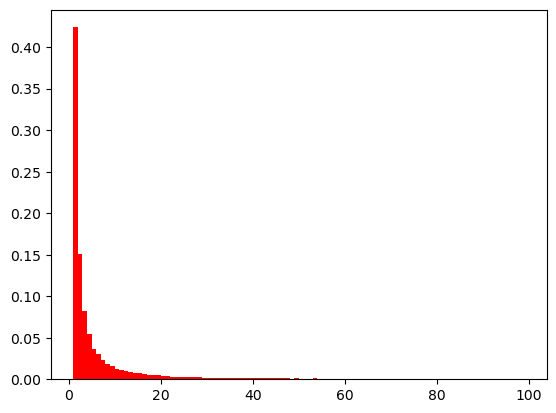

In [29]:
dd_h, dd_h_bins, _ = plt.hist(g_deg, bins=range(1,100), density=True, color = 'red')
#g_deg contiene il grado di tutti i nodi del grafo. Con i gradi su un grafo molto grande con questi array ci facciamo poco e niente. quindi dobbiamo fare il plotting e fitting della degree distribution
#X valori che si trovano nell'array e sulle y il numero di volte che quel valore compare
# Nodi di grado 1 c'è il 40%, nodi di grafo 50 forse lo 0.006%
# La parte iteressante è la coda e quindi questo strumento non è giusto per visualizzare questa informazione

Text(0.5, 0, 'd')

Text(0, 0.5, 'P(Degree = d)')

Text(0.5, 1.0, 'Degree density on a log-log scale')

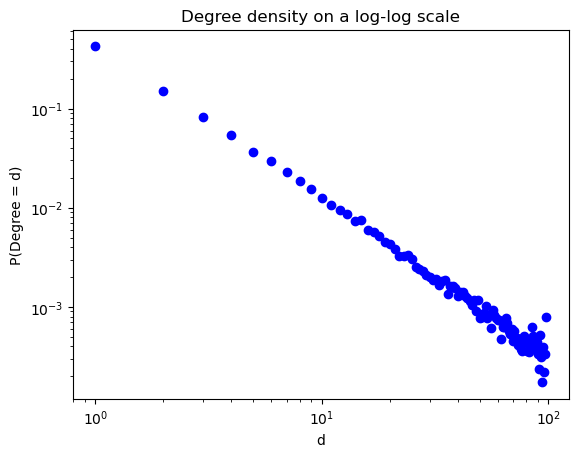

In [30]:
# Degree density on a loglog scale
plt.loglog(dd_h_bins[:-1], dd_h, 'bo')
plt.xlabel("d")
plt.ylabel("P(Degree = d)")
plt.title("Degree density on a log-log scale")
#Qui permette di calcolare il plot in scala log log: plotto in scala log log la densità della distribuzione dei gradi
#densità del grafo di Reddit in scala log log
#la coda decade in modalità piuttosto lineare
# Osservando anche gli esempi ed esperimenti svolti durante il corso, questo grafico ci suggerisce che la coda è pesante
# per analizzare con più precisione i valori di densità per i nodi con grado alto usiamo la CCDF nel plot successivo

(0.0, 100.0, 0.0, 1.0)

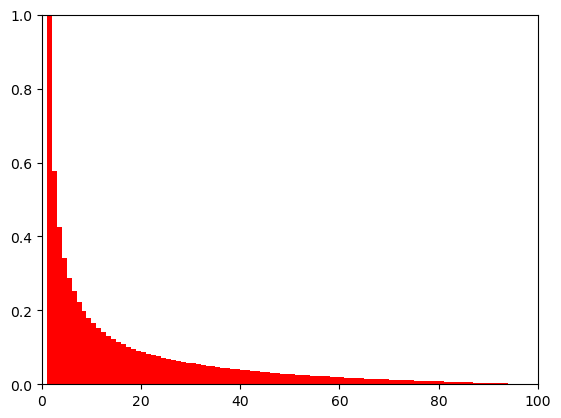

In [31]:
# Compute the CCDF - we can use 2 ways
# 1. use the histogram functions with parameter cumulative=-1 gives the CCDF
# è quello che si usa 
dd_h, dd_h_bins, _ = plt.hist(g_deg, bins=range(1,100), density = True, color = 'red', cumulative = -1)
plt.axis([0,100,0,1])
#il valore della CCDF su un nodo di grado minimo è sempre 1 perchè questa è la probabilità 
# di avere nodi con grado>= a quello che stiamo considerando. Quindi la CCDF sul valore 1  ha sempre valore 1 

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a lin-lin scale')

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a log-log scale')

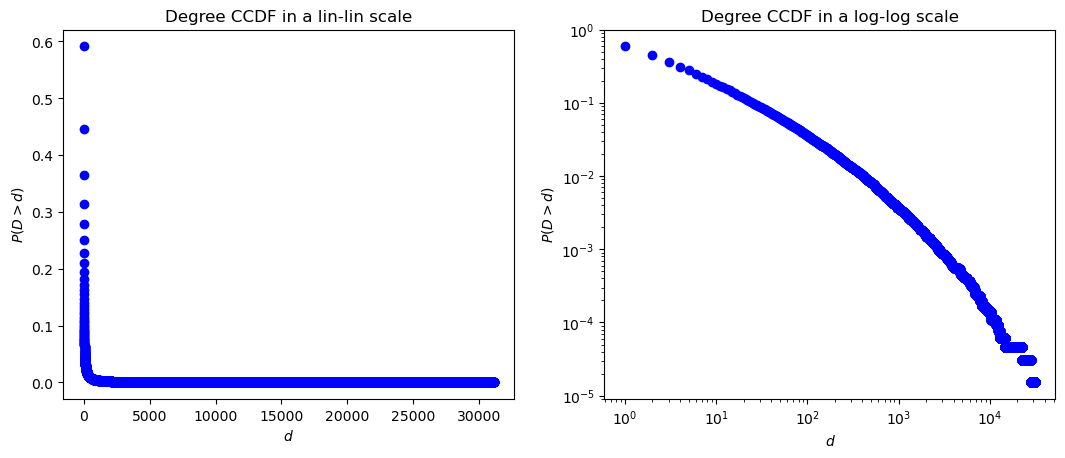

In [32]:
# ECDF function of statsmodels.distributions.empirical_distribution
# ECDF(dataset) returns a the empirical CDF computed from the dataset, which can be used as a FUNCTION
# - i.e., it is possible to call ECDF(x) for any x, irrespective of the set of data from which the ECDF is derived
deg_cdf = ECDF(g_deg) #restituisce una funzione che approssima la cumulative distribution function
# calcolata sui gradi che gli diamo come parametri. In questo caso quindi calcoliamo la probabiulità che il grado sia minore dei valori considerati

# scale the fig size twice in length
default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])

# generate a figure with 2 subplots, organised in 1 row and 2 columns
# ax1 and ax2 ("axes") are used to access the individual plots
# NB: in case of more rows, axes must be specified as list of lists, e.g., for 2x2 ((ax1,ax2),(ax3,ax4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = fig_sizes)

# plot the CCDF in lin-lin and log-log scales
# see http://matplotlib.org/api/axes_api.html for the API of the Axis class
# see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot or the Axes.plot() documentation
# for the parameters of the plot method
degs = np.arange(1,max(g_deg)+1)

ax1.plot(degs, 1-deg_cdf(degs), 'bo')
ax1.set_xlabel("$d$")
ax1.set_ylabel("$P(D>d)$")
ax1.set_title("Degree CCDF in a lin-lin scale")

ax2.loglog(degs, 1-deg_cdf(degs), 'bo') #calcolo il complementare della CDF, in modo da avere la CCDF
ax2.set_xlabel("$d$")
ax2.set_ylabel("$P(D>d)$")
ax2.set_title("Degree CCDF in a log-log scale")
# i dati sono gli stessi però in scala diversa. In scala lineare la curva si appiettisce e quindi la coda non si vede. 
# Per vedere questa parte di ditribuzione bisogna usare la scala log log
# il pot della CCDF è una curva diversa e molto più pulita. 
# il fatto che la densità e la ccdf siano due curve abbasatnza simili visivamente su una scala log log è un ulteriore indicazione che effettivamente quella distribuzione
# è una distribuzione power low (coda pesante)

# Part 5. Equivalent graphs and fitting

## Random graphs



65643

65648

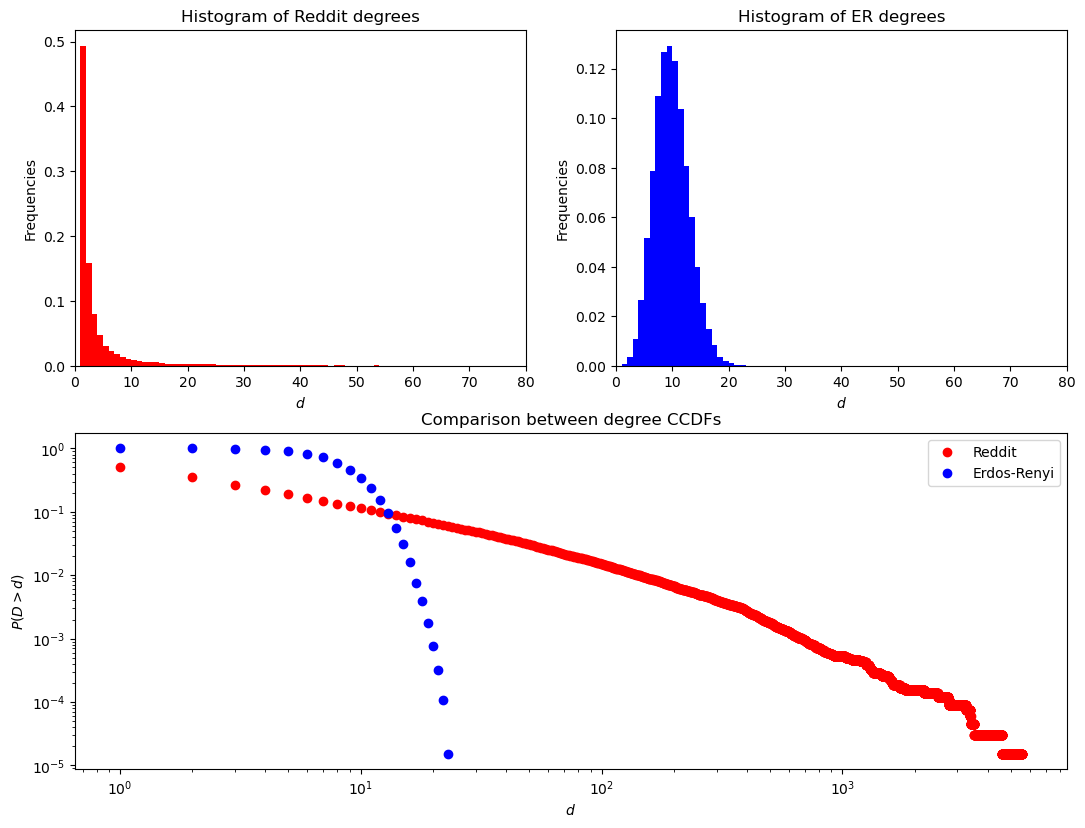

In [11]:
# scale the fig size twice in length
default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])


# Now we compare the degree distributions for the complete Reddit Giant Component
er_p_GC = mean(g_GC_u.degree())/g_GC_u.vcount() #grado medio/numero dei nodi = parametro P del mio grado ER equivalente
er_reddit_all = Graph.Erdos_Renyi(g_GC_u.vcount(), er_p_GC) # genera unn oggetto grafo ma nessuno mi garantisce che
#questo grafo di ER sia un unico componente connesso

# take only the Giant Component
# Mi estraggo il giant component e vado a confrontare il numero dei nodi
#del grafo Giant component di ER e lo confronto con il numero dei nodi del grafo di reddit che voglio analizzare
er_reddit = er_reddit_all.connected_components(mode = "WEAK").giant()
er_reddit.vcount()
g_GC_u.vcount()


# we use GridSpecs for a finer control of the plot positioning
fig_sizes = (fig_sizes[0], 2*default_sizes[1])
f = plt.figure(figsize = fig_sizes)

# create a 2x2 Grid Specification
gs = gridspec.GridSpec(2, 2)

# add subplots to the figure, using the GridSpec gs
# position [0,0] (upper-left corner)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
# the third plot spans the entire second row
ax3 = plt.subplot(gs[1,:])

# compute and plot the histogram of Reddit degrees
d_g = g_GC_u.degree()
_,_,_ = ax1.hist(d_g, bins=range(1,max(d_g)+2), density = True, color = 'red')
_ = ax1.set_xlim(0,80)
_ = ax1.set_xlabel("$d$")
_ = ax1.set_ylabel("Frequencies")
_ = ax1.set_title("Histogram of Reddit degrees")


# compute and plot the histogram of ER degrees
d_er = er_reddit.degree()
_,_,_ = ax2.hist(d_er, bins=range(1,max(d_er)+2), density = True, color = 'blue')
_ = ax2.set_xlim(0,80)
_ = ax2.set_xlabel("$d$")
_ = ax2.set_ylabel("Frequencies")
_ = ax2.set_title("Histogram of ER degrees")

# compute and plot the degree CCDFs
g_ecdf = ECDF(d_g)
er_ecdf = ECDF(d_er)
x = np.arange(1,max(d_g)+1)
_ = ax3.loglog(x, 1-g_ecdf(x), 'ro', label = 'Reddit')
x = np.arange(1,max(d_er)+1)
_ = ax3.loglog(x, 1-er_ecdf(x), 'bo', label = 'Erdos-Renyi')
_ = ax3.set_xlabel("$d$")
_ = ax3.set_ylabel("$P(D>d)$")
_ = ax3.set_title("Comparison between degree CCDFs")
_ = ax3.legend(numpoints = 1)

# Grafo ER 65643
# Grafo di partenza 65648

# Mi va bene questa differenza perchè è una differenza trascurabile in quanto la differenza tra numero di nodi e numero di edge 
# sia molto più piccola rispetto al numero totale di nodi ed edge che abbiamo nel nostro grafo
# quindi va bene considerare il giant component del grafo equivalente che abbiamo calcolato 
# quando guardo le due densità mi accorgo che queste sono diverse: la densità direddut ha un andamento descrescente, 
# sembra che ci sia una coda più pesante in quanto ci sono dei valori sui 40-50
# se giardo il grafo di ER equivalente l'andamento è diverso è una forma a campana attorno al valore 10
# il quale è il grado medio. Non ci sono gradi alti
# Mi plotto le ECDF del grafo di reddit e quello equivalente di er se confronto le due distribuzioni sono cosi diverse perchè
# non dipende dal fatto che ho sbagliato a configurare la funzione di ER quando l'ho chiamata, 
# ma è che il grafo di reddit è diverso da un ER per quanto riguarda il grado

In [12]:
#La curva del grafo di ER decade molto più velocemente, ha una coda più leggera rispetto a quella di reddit
#Osservazione: il grafo che  abbiamo prodotto è il grafo della famiglia
#ER più vicino possibile al mio grafo reddit. Nessun grafo costruito secondo il modello ER è più 
#vicino di questo al mio grafo di partenza
#Il grafo di reddit è diverso dalla distribuzione di ER per quanto riguarda il grado non è
#che esiste un grafo di ER che mi dà una configurazione del grado più vicina a quella di reddit

## Power Laws

In [13]:
# to fit power law distributions
# si possono generare dei grafi con distribuzione power low - è equivalente con la ER però con power low
# per capire A devo capire qual è la distribuzione power low che meglio fitta i miei dati
xmin = 50
fit_pl = Fit(g_GC_u.degree(), xmin = xmin)
# by computing automatically the "best" xmin value
fit_pl_auto = Fit(g_GC_u.degree())

exp_pl_auto = fit_pl_auto.alpha #gamma in slide è quello che se sta tra 2-3 coda pesante, >3 al limite di coda pesante ecc
xmin_auto = fit_pl_auto.xmin #la migliore approssimazione possibile vale solo per le 
# x > x_min e con le x < xmin nn è una buona approssimazione
exp_pl = fit_pl.alpha
print ("PL exponents: (xmin=%d) %.2f; (auto xmin=%.2f) %.2f" % (xmin, exp_pl, xmin_auto, exp_pl_auto))
#il problema sull'uscita è che sulla coda abbiamo dati sporchi e inoltre i dati reali sono pochi e quindi andarsi a 
# fidare solo dei valori alti (10^3) in avanti non è una buona idea
# in questo caso fare un fitting solo sui dati di 10^3 in avanti non è buona idea perchè sui dati reali c'è
# sempre sporcizia in valori alti.
# QUESTA SAREBBE LA PROCEDURA CHE HA PROPOSTO
# gli faccio il fitting migliore partendo da 10 in avanti, esperienza nel guardare i dati nel senso 
# che a 10 cominicio a vedere un andamento rettilineo
# Il fitting va fatto ad almeno un paio di decadi.
# il fit a 2.15 è relativo a quell'intervallo di valori xmin mentre il 2.89 è calcolato 
# su un range che va da 369 in avanti. nel 2.15 il fitting è rappresentativo e quindi dobbiamo imporre il fitting

# compute the number of nodes and edges of the graph to generate the equivalent static Power Law graph
N = g_GC_u.vcount()
M = g_GC_u.ecount()

# Equivalent graph for the fitting with fixed xmin
pl_db_all = Graph.Static_Power_Law(N, M, exp_pl)
# the graph could not be connected, so keep the GC only
pl_db = pl_db_all.connected_components(mode = "WEAK").giant()

# Equivalent graph for the fitting with automatic xmin
pl_db_auto_all = Graph.Static_Power_Law(N, M, exp_pl_auto)
pl_db_auto = pl_db_auto_all.connected_components(mode = "WEAK").giant()

Calculating best minimal value for power law fit
PL exponents: (xmin=50) 2.15; (auto xmin=369.00) 2.89


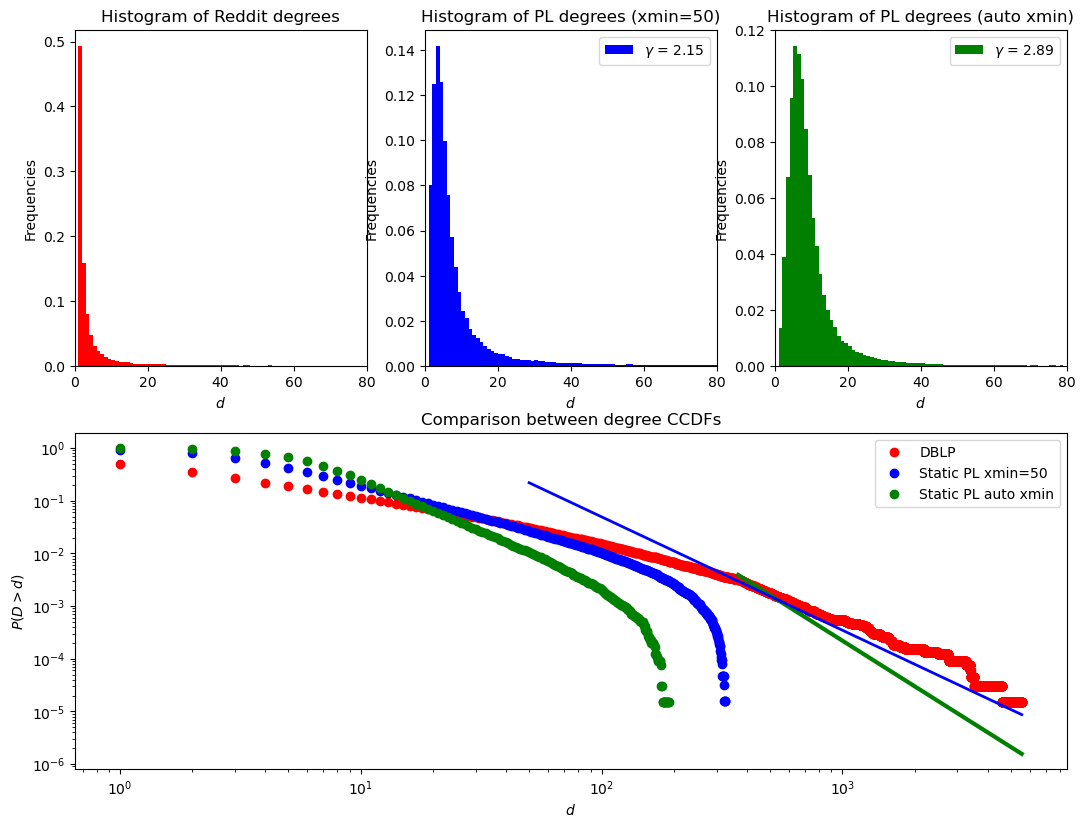

In [14]:
# we use GridSpecs for a finer control of the plot positioning
# scale the fig size twice in length
default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])

fig_sizes = (fig_sizes[0], 2*default_sizes[1])
f = plt.figure(figsize = fig_sizes)

# create a 2x3 Grid Specification
gs = gridspec.GridSpec(2, 3)

# add subplots to the figure, using the GridSpec gs
# position [0,0] (upper-left corner)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
# the fourth plot spans the entire second row
ax4 = plt.subplot(gs[1,:])

# compute and plot the histogram of DB degrees
d_db = g_GC_u.degree()
_,_,_ = ax1.hist(d_db, bins=range(1,max(d_db)+2), density = True, color = 'red')
_ = ax1.set_xlim(0,80)
_ = ax1.set_xlabel("$d$")
_ = ax1.set_ylabel("Frequencies")
_ = ax1.set_title("Histogram of Reddit degrees")

# compute and plot the histogram of Static Power Law degrees with set xmin
d_pl = pl_db.degree()
_,_,_ = ax2.hist(d_pl, bins=range(1,max(d_pl)+2), density = True, color = 'blue', label = "$\gamma$ = %.2f" % exp_pl)
_ = ax2.set_xlim(0,80)
_ = ax2.set_xlabel("$d$")
_ = ax2.set_ylabel("Frequencies")
_ = ax2.set_title("Histogram of PL degrees (xmin=%d)" % xmin)
_ = ax2.legend()

# compute and plot the histogram of Static Power law degrees with auto xmin
d_pl_auto = pl_db_auto.degree()
_,_,_ = ax3.hist(d_pl_auto, bins=range(1,max(d_pl_auto)+2), density = True, color = 'green', label = "$\gamma$ = %.2f" % exp_pl_auto)
_ = ax3.set_xlim(0,80)
_ = ax3.set_xlabel("$d$")
_ = ax3.set_ylabel("Frequencies")
_ = ax3.set_title("Histogram of PL degrees (auto xmin)")
_ = ax3.legend()

# compute and plot the degree CCDFs
db_ecdf = ECDF(d_db)
pl_ecdf = ECDF(d_pl)
pl_auto_ecdf = ECDF(d_pl_auto)
x = np.arange(1,max(d_db)+1)
_ = ax4.loglog(x, 1-db_ecdf(x), 'ro', label = 'DBLP')
x = np.arange(1,max(d_pl)+1)
_ = ax4.loglog(x, 1-pl_ecdf(x), 'bo', label = 'Static PL xmin=%d' % xmin)
x = np.arange(1,max(d_pl_auto)+1)
_ = ax4.loglog(x, 1-pl_auto_ecdf(x), 'go', label = 'Static PL auto xmin')
_ = ax4.set_xlabel("$d$")
_ = ax4.set_ylabel("$P(D>d)$")
_ = ax4.set_title("Comparison between degree CCDFs")
_ = ax4.legend(numpoints = 1)

# for reference, plot the power law functions corresponding to the fitting with fixed and automatic xmin
x1 = np.arange(xmin_auto, max(d_db)+1)
_ = ax4.loglog(x1, 100000 * x1**(-exp_pl_auto), 'g-', linewidth = 3)
x1 = np.arange(xmin, max(d_db)+1)
_ = ax4.loglog(x1, 1000 * x1**(-exp_pl), 'b-', linewidth = 2)

# Plotto le distribuzioni power low come le distribuzioni di ER. 
# B: grafo power low equivalente il cui grafo ha lo stesso numero di nodi e link il cui gamma è 2.15
# C: grafo power low con lo stesso numero di nodi e link ma con gamma 2.89
# Nell'ultimo plot plottiamo la CCDF. le rette verdi e blu hanno pendenza pari alle loro gamma
# i pallini blu si allineano molto meglio ai pallini rossi rispetto ai verdi e questo ci conferma che il grafo equivalente 
#calcolato con il fitting automatico in realtà non mi restituisce un grafo simile al mio
# Cosa c'è di simile tra il verde e il rosso: gli andamenti del grafico sono simili per range piccoli 
# in particolare per 200/300 in avanti
# Il grafo blu approssima la distribuzione del grado su un range di 200 in avanti.
# Sulla parte più pesante della coda il blu e la verde hanno un approssimazione più o meno simile
# però questo non mi disturba perchè cmq in questa zona con i valori estremi è sempre imprecisa 
# perchè basata su pochi dati. Devo vedere quindi la struttura della distribuzione
# L'area di 1000 in avanti non è affidabile e quindi quella affidabile è quella nella 
# quale si considerano un paio di decadi dal grado massimo

In [15]:
#Conclusione: la mia rete reddit è approssimata male da una rete ER e quindi sicuramente non ha una coda leggera.
#è approssimata piuttosto bene da una distribuzione che ha coda pesante e la pesantezza della coda è abbasatanza 
#pesante perchè l'approssimazione che abbiamo calcolato su un range di valori sufficientemente grande 
#(2 decadi rispetto al massimo) ha un gamma = 2.15 quindi la mia distribuzione del grado è una power low con gamma = 2.15

# Part 6. Assortativity

-0.12845202666889538

Text(0.5, 0, 'degree')

Text(0, 0.5, 'Neighbors degree')

Text(0.5, 1.0, '$knn$ index')

Text(0.5, 0, 'degree')

Text(0, 0.5, 'Average degree of neighbors')

Text(0.5, 1.0, '$knnk$ index')

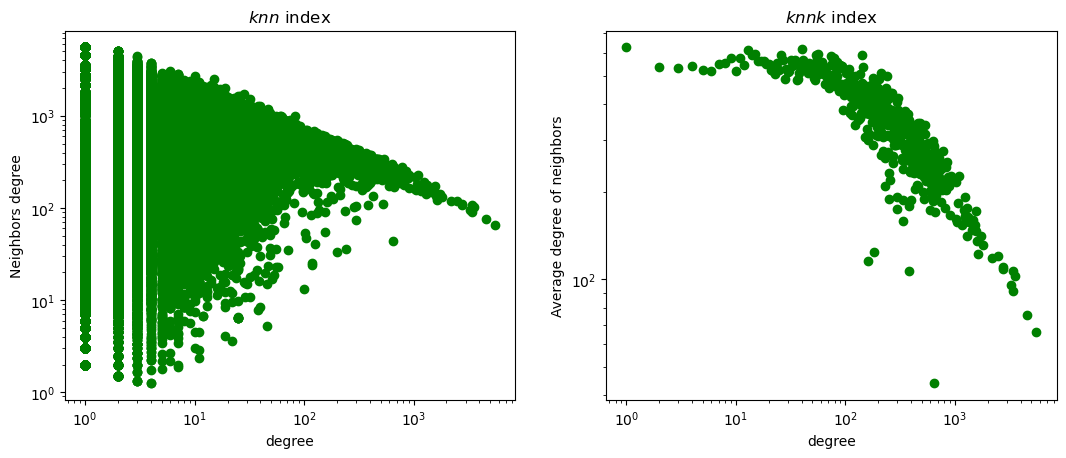

In [16]:
# assortativity
# assortativity index
# questo metodo permette di calcolarmi l'indice r
g_GC_u.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
reddit_knn, reddit_knnk = g_GC_u.knn()
# il primo vettore è grosso quanto è la dimensione della rete in termini di numero di nodi in cui in posizione
# 0 c'è l'indice knn del nodo 0 e cosi via

# plotting
default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = fig_sizes)
ax1.loglog(d_g, reddit_knn, 'go')
ax1.set_xlabel("degree")
ax1.set_ylabel("Neighbors degree")
ax1.set_title("$knn$ index")
# per ogni nodo sulle x ho il valore del suo grado e sulle y il knn di quel nodo
# se prendo sull'ascisse 1 allora questo corrisponde a tutti i nodi che hanno grado 1. I punti sulle y sono 
# i knn di tutti i nodi che hanno grado 1: sono i gradi del vicino dei nodi che hanno grado 1
# Dal gradfico però non si riesce a capire l'andamento dato che è tutto sovrapposto -> passare al knnk


ax2.loglog(range(1,max(d_g)+1), reddit_knnk, 'go')
ax2.set_xlabel("degree")
ax2.set_ylabel("Average degree of neighbors")
ax2.set_title("$knnk$ index")
# si ottiene prendendo tutti i punti del grafico di sx che corrispondono ad un certo valore delle x e se ne fa una media
# il knnk altro non è che la media dei punti che troviamo sulla strisciata verticale


In [17]:
#Questo grafico dominuisce al variare di k e quindi questo conferma il valore 31143 e quindi la rete è disassortativa. 
#Dobbiamo analizzare tutti gli indici perchè non sempre c'è correlazione o meglio interpredabili. 
#In questo è chiaro l'andamento disassortativo. 

#Se per esempio ci sono ambiguità del tipo un andamento non chiaro allora
#c'è da fare osservazioni. Il fatto che sulla dx del plot di knnk non hanno un bel andamento chiaro è
#perchè i nodi a grado alto sono molto pochi rispetto ai nodi di grado basso 
#(sui nodi a grado basso la statistica che ci stiamo calcolando ossia il valor medio è calcolato su tanti
#dati mentre la statistica per i nodi a grado alto è calcolato su pochi dati dato che nodi a grado alto
#sono pochi all'interno della rete). La variabilità sulla destra del grafico è sempre molto alta, 
#infatti se ci calcoliamo r sulla dx questo potrebbe essere zero per il fatto che i punti sulla destra sono sporchi. 

# Part 7. Clustering

In [18]:
# clustering
# global transitivity (C1)
# C1 è il rapporto tra numero totale triangoli e triplette che troviamo in rete 
print("Global clustering (C1): ", g_GC_u.transitivity_undirected())

# average local transitivity (C2)
# mode = 0 means that nodes with less than two neighbours will have zero transitivity
#C2 è il valor medio dei cluster locali: rapporto del numero totale trinaogli e triplette e poi faccio 
#la media su tutta la rete
print ("Local clustering (C2): ", g_GC_u.transitivity_avglocal_undirected(mode="zero")) # calcola C2 mode = zero -->
# nodi con meno di due vicini che non possono contribuire alla transitività si asusme che  abbiano un contributo pari a zero

# local transitivity for all vertices
print("Local transitivity for first 10 vertices")
local_trans = g_GC_u.transitivity_local_undirected(mode="zero")
# calcola il cluster locale su tutti i nodi e me lo restituisce come un array
local_trans[0:9]
print("AVG local transitivity: ", mean(local_trans))

# Clustering coefficient of the equivalent ER graph (avg_degree/#nodes)
er_cc = mean(d_g)/g_GC_u.vcount()
print("Clustering coefficient of the equivalent ER graph: ", er_cc)

Global clustering (C1):  0.055799481151184875
Local clustering (C2):  0.2218819057749045
Local transitivity for first 10 vertices


[0.033817095232315526,
 0.1619047619047619,
 0.35333333333333333,
 0.04861985924035732,
 0.17316017316017315,
 0.25757575757575757,
 0.07096723897021343,
 0.051993937671687036,
 0.12404371584699453]

AVG local transitivity:  0.22188190577490147
Clustering coefficient of the equivalent ER graph:  0.0001433240705204382


In [19]:
# Sulla base di questi numeri la nostra rete ha un clustering alto o basso? 
#Il coefficiente di clustering del grafo ER equivalente lo stimiamo con il parametro p il quale è uguale 
#al grado medio della rete / numero dei nodi. la nostra rete Reddit ha 60k nodi, 1/60k = 10^-4 quindi
#il cluster che ci attendiamo come ordine di grandezza del grafo ER equivalente è 10^-4 quindi dobbiamo confrontare
##questi due numeri. Confrontando i due numeri la nostra rete è poco o tanto clusterizzata?
#C1 e C2 in termini assoluti sono valori non alti perchè il clustering è un valore che sta tra 0 e 1,
#però se confrontiamo con la dimensione della rete e quindi confrontiamo con grafi equivalenti che sappiamo che 
#per quella dimensioni essere sono poco clusterizzati. Quindi se confrontiamo come ci aspettiamo che sia clusterrizata una 
#rete con tali dimensioni e quindi nek caso di basso clustering nel modello di ER otteniamo che in realtà questa rete
#è significativamente clusterizzata.  

# Part 8. Centrality

In [20]:
# we use a subset of the graph, for computational purposes, i.e., we pick the subgraph of nodes in the GC with degree>60
# Questi indici li calcolo solo nel sottografo
idx = np.argwhere(np.array(g_GC_u.degree())>40).flatten()
sub_g = g_GC_u.induced_subgraph(idx) # mi genera un sottografo ed estrae i nodi che gli diamo come parametro ed estranedo i link quei nodi che
# gli stiamo dando come parametro. Faccio nel sottografo per motivi computazionali (problemi con betweeneess)

print("Closeness centrality (first 10):")
sub_g.closeness()[0:9]

print("Betweenness centrality (first 10):")
sub_g.betweenness()[0:9]

# edge betweenness, and edge with the maximum edge betweenness
edge_bet = sub_g.edge_betweenness() #sono indici molto costosi da calcolare
idx_max = np.argmax(edge_bet)
print("Index of edge with max betweennes:", idx_max)
print("Max edge betweenness:", edge_bet[idx_max])
print("Nodes:", sub_g.es[idx_max].tuple) #mi ritorna la coppia di id dei nodi collegati da quell'edge

Closeness centrality (first 10):


[0.5532676812891674,
 0.5361093038386467,
 0.5362255965292841,
 0.520749947335159,
 0.49018441403926233,
 0.5171548117154812,
 0.494498899779956,
 0.5369244135534318,
 0.5639972621492129]

Betweenness centrality (first 10):


[8419.771459705762,
 3898.187979243959,
 5365.469473233525,
 2004.0014328644218,
 27.150759843053688,
 2068.49834336647,
 287.738712398567,
 6084.492626190373,
 11907.264086223337]

Index of edge with max betweennes: 84536
Max edge betweenness: 2472.0
Nodes: (37, 1920)


# Part 9. Shortest path length

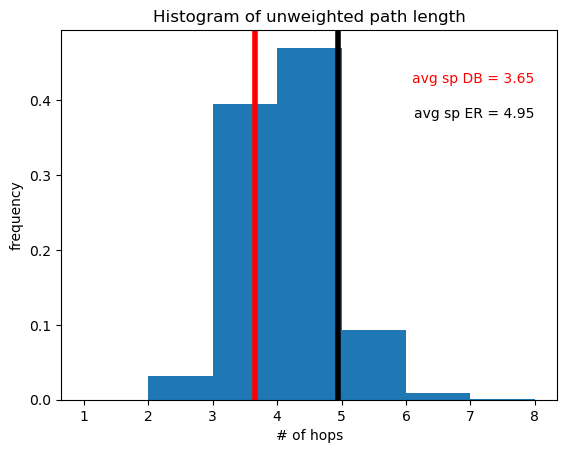

In [21]:
#Calcola gli shortest path
#Prendo 200 nodi src e 200 nodi trg random --> problemi computazionali
src = sample(list(g_GC_u.vs), 200)
trg = sample(list(g_GC_u.vs), 200)
# PROCEDURA CHE HA PROPOSTO
# l'idea è che per rednere il tutto più rigoroso parto da un valore esempiio 100, far eseguire il codice
# calcolarmi il valor medio ottenuto prendendo 50 src e 50 trg poi passare da 50 a 100 rifare la stessa cosa e 
# vedere il nuovo valor medio che ottenevo. Aumento il numero finchè il valor medio non si stabilizza entro un certo 
# range di variabilità che posso definire entro il 2%. Cioè considero un numero crescente di coppie di nodi
# mi calcolo lo shortest path e ad un certo punto vedo che il valor medio dello shortest path mi si stabilizza
# se considero troppe coppie di nodi ho una grande variabilità ma quando considero un numero suffieicienti di coppie di nodi
# allora stiamo campionando un sottoinsieme sufficientemente rappresentativo di nodi src e trg da epslorare le possibili
# lunghezze degli shortest path cosicchè la distribuzione e il suo valor medio diventano costanti e a quel punto non mi cambieranno più
# posso fermarmi perchè ho trovato un valore approssimativamente uguale a quello che sto cercando che è il valore dello shortest path medio
# in generale il valore 100 non ci fa fare grandi sorprese

# compute the UNWEIGHTED shortest paths
# - result is a matrix, while we need an array for plotting
n_hops_u = g_GC_u.distances(source = src, target = trg, weights = None, mode = "all")
# lo fa attraverso questa funzione
#Prende due insieme di nodi src e trg e i pesi e calcola gli shortest path tra tutti i nodi che sono nell'ineieme di src e trg
# calcola gli shortest path  e restituisce la lunghezza dei cammini minimi altrimenti se weight è diverso da none
# restituisce il costo dei cammini a costo minimo. 
# Quindi se ci sono i pesi restituisce o il costo minimo o la lunghezza del numero minimo di hiop se non ci sono i pesi
# A noi interessa la visione topologica e quindi senza i pesi
n_hops_u = np.array(n_hops_u).flatten() #dalla matrice in array
 
# plot
max_hops = max(n_hops_u)
nhops_densities, _, _ = plt.hist(n_hops_u, bins = range(1,max_hops+2), density = True)
_ = plt.axvline(mean(n_hops_u), color = 'red', linewidth = 4)
_ = plt.xlabel("# of hops")
_ = plt.ylabel("frequency")
_ = plt.title("Histogram of unweighted path length")
_ = plt.text(max_hops+1, 0.9*max(nhops_densities), "avg sp DB = {:.2f}".format(mean(n_hops_u)),
             color = "red", horizontalalignment = "right")

# expected average shortest path for ER graphs (with exponential degree distribution)
ex_avg_sp = np.log10(g_GC_u.vcount())/np.log10(2*g_GC_u.ecount()/g_GC_u.vcount()) # X
_ = plt.axvline(ex_avg_sp, color = 'black', linewidth = 4)
_ = plt.text(max_hops+1, 0.8*max(nhops_densities), "avg sp ER = {:.2f}".format(ex_avg_sp),
             color = "black", horizontalalignment = "right")
# La riga nera è il valore stimato dello shortest path del grafo equivalente ER calcolato senza
# generare il grafo di ER stesso ma usando il valore stimato analitivo X --> ex_avg_sp (vedi segno su)

In [34]:
#La riga verticale in corrispondenza del valor medio. ottengo questa distribuzione di path il cui valor medio è intorno a 5. 
#Quello che ci dobbiamo aspettare è log del numero dei nodi / logaritmo del grado medio però in prima approssimazione possiamo 
#considerare il log del numero dei nodi perchè a rete ha 60k nodi e log di 60k è 4 e il fatto che ci sia 5 anzicchè 5 è perchè
#c'è quel fattore a dividere (log del grado medio è < 1 e quindi fa aumentare il grado medio da 4 a 5). 
#Questa analisi dei path non mi dice granchè solo che non ci sono strutture particolarmente strane da andare 
#ad analizzare nella mia rete. 

# Part 10. Community detection

In [38]:
# take only a subgraph, otherwhise the analysis will be too computationally intensive
idx = np.argwhere(np.array(g_GC_u.degree())>50).flatten()
sub_g1 = g_GC_u.induced_subgraph(idx)
#tiro  fuori il sotoografo dei nodi che hanno grado maggiore di 100

# giant component
sub_g1_gc = sub_g1.connected_components(mode="WEAK").giant()
#quindi la community detection la faccio sul giant component

# Fastgreedy algorithm
vd = sub_g1_gc.community_fastgreedy() #community detection che estrae le commmunity secondo l'idea di massima modularità

# The number of detected communities
vd.optimal_count #possiamo vedere solo il numero di comunità che sono state trovate


# convert to a cluster object to plot it nicely
vd_clust = vd.as_clustering() #vediamo l'oggetto come un oggetto che ritorna la connected components
#plot(vd_clust, layout=sub_g1_gc.layout_fruchterman_reingold(), mark_groups = True)
# è la stessa chiamata che faccio sui componenti connessi e ottengo i gruppi/comunità
# i link intra sonno neri e inter sono grigi 

# sizes dimensioni delle comuninità
vd_clust.sizes()

# membership
#vd_clust.membership

# identify the indices of edges that cut across different communities
cros = np.array(vd_clust.crossing()) #mi prendo i link intercommunity quelli che mi collegano comunità differenti
print("Num Edges inter community: ", len(intercommunity))
intercommunity = np.argwhere(cros == True).flatten()
#Ottengo gli indici necessari per poter fare un attacco di MBA sono gli indici degli edge intercommunity


# edge betweenness, and edge with the maximum edge betweenness
edge_bet = sub_g1_gc.edge_betweenness() #sono indici molto costosi da calcolare
idx_max = np.argmax(edge_bet)
print("Index of edge with max betweennes:", idx_max)
print("Max edge betweenness:", edge_bet[idx_max])

# graph corresponding to the biggest community
bigC = vd_clust.giant() #estraggo la comunità di dimensione maggiore
print("Biggest community: ")
summary(bigC, verbosity = 1, edge_list_format = "edgelist", max_rows = 8)

# plot of the biggest community
#plot(bigC, layout = bigC.layout_fruchterman_reingold())

4

[934, 281, 786, 8]

Num Edges inter community:  45757
Index of edge with max betweennes: 51593
Max edge betweenness: 1984.0412007485963
Biggest community: 
IGRAPH UNW- 934 30042 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
                edge              weight
[0]   leagueoflegends--soccer         16
[1]   leagueoflegends--nfl             5
[2]   soccer--nfl                      3
[3]   playmygame--gamedev             17
[4]   leagueoflegends--dogecoin        5
[5]   soccer--dogecoin                 1
[6]   playmygame--dogecoin             1
[7]   gamedev--dogecoin                5


# Part 11. Comparison with Equivalent Graphs

## Random Graph

### Assortativity

-0.12845202666889538

-0.002071803987756055

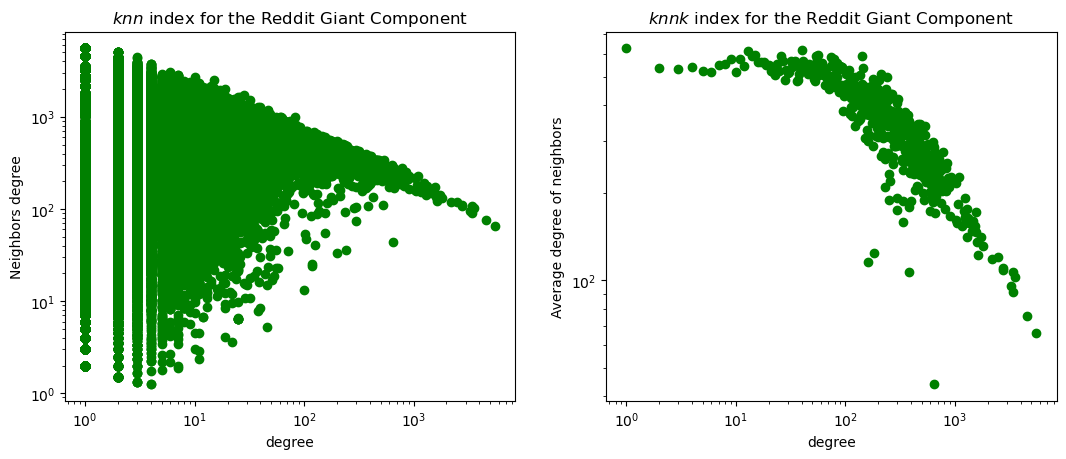

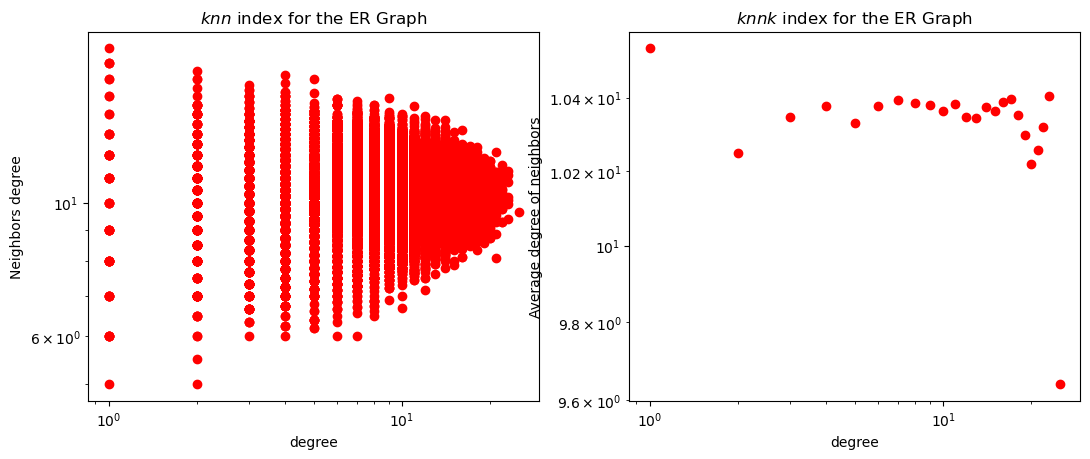

In [23]:
# The global assortativity coefficient - we will need the undirected version of the graph from now on
g_GC_u.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
reddit_knn, reddit_knnk = g_GC_u.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(g_GC_u.degree(), reddit_knn, 'go')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the Reddit Giant Component")

_ = ax2.loglog(range(1,max(g_GC_u.degree())+1), reddit_knnk, 'go')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the Reddit Giant Component")



# The global assortativity coefficient
er_reddit.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
er_knn, er_knnk = er_reddit.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(er_reddit.degree(), er_knn, 'ro')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the ER Graph")

_ = ax2.loglog(range(1,max(er_reddit.degree())+1), er_knnk, 'ro')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the ER Graph")

### Clustering

In [24]:
g_GC_u.transitivity_undirected()
g_GC_u.transitivity_avglocal_undirected(mode="zero")

er_reddit.transitivity_undirected()
er_reddit.transitivity_avglocal_undirected(mode="zero")

0.055799481151184875

0.2218819057749045

0.0001466305648119229

0.00015013000187021676

### Shortest Path

In [25]:
# Shortest path lenght
# on a subset of the nodes, as otherwise it will take forever to compute
reddit_vs_src = sample(list(g_GC_u.vs), 1000)
reddit_vs_trg = sample(list(g_GC_u.vs), 1000)
er_vs_src = sample(list(er_reddit.vs), 1000)
er_vs_trg = sample(list(er_reddit.vs), 1000)

reddit_sp = mean(np.array(g_GC_u.distances(reddit_vs_src, reddit_vs_trg, weights=None)).flatten())
reddit_sp
g_GC_u.vcount()
mean(np.array(er_reddit.distances(er_vs_src, er_vs_trg)).flatten())
er_reddit.vcount()

3.643967000000109

65648

5.223271999999996

65646

## Power Law Graph

### Assortativity

-0.12845202666889538

-0.0014793977135746873

-0.0018715428654198514

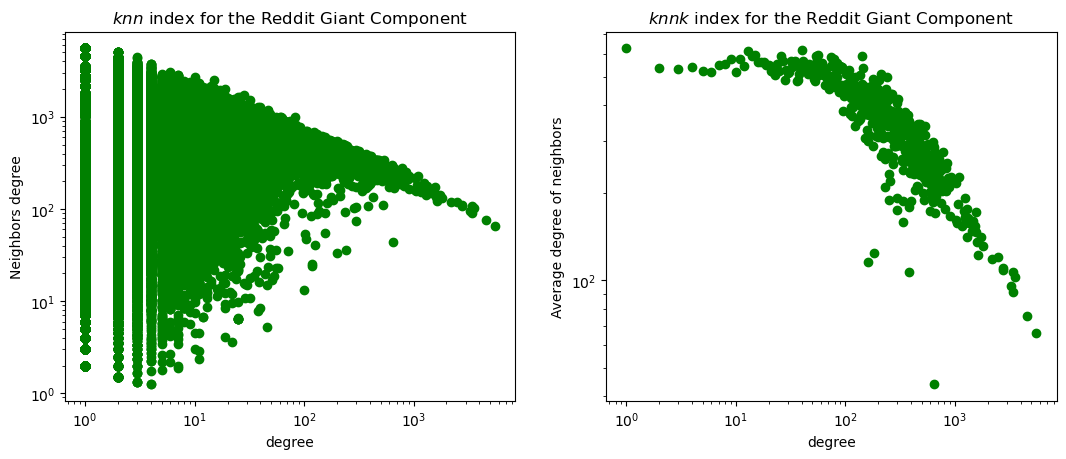

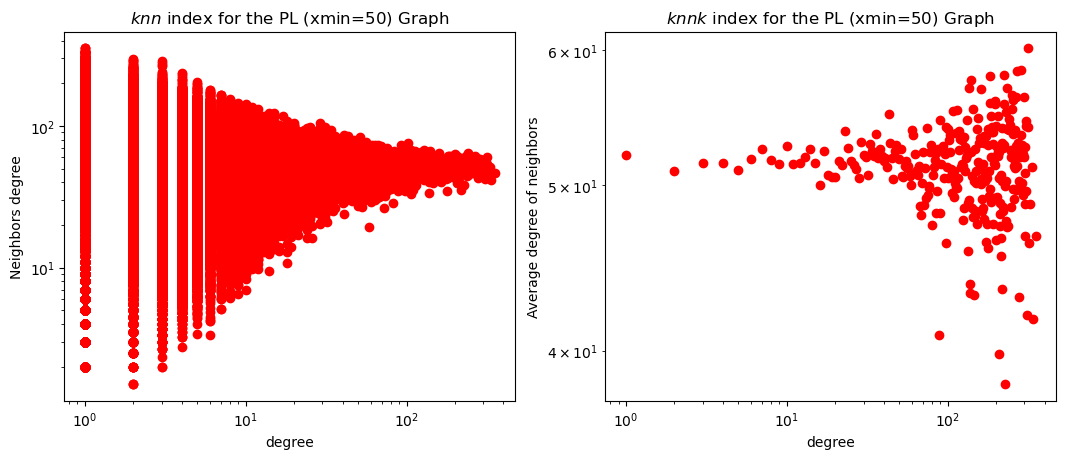

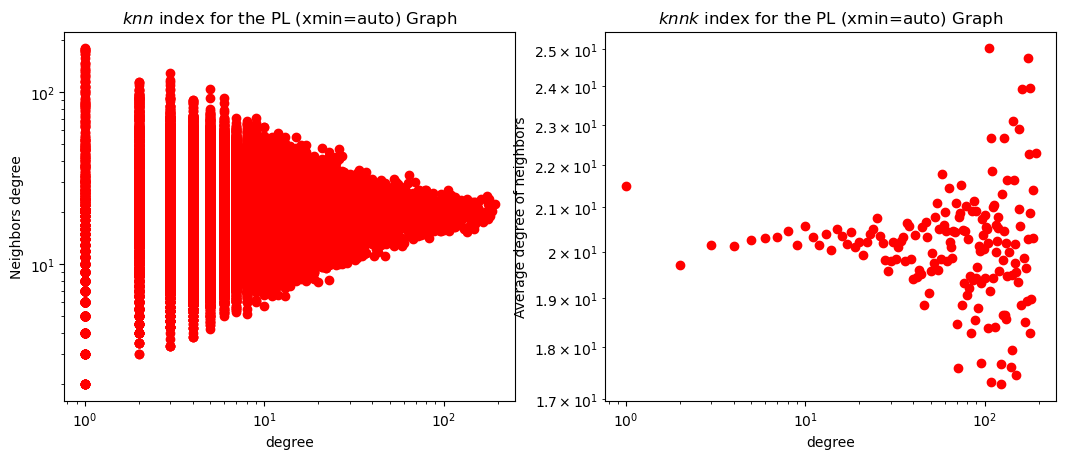

In [26]:
# The global assortativity coefficient - we will need the undirected version of the graph from now on
g_GC_u.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
g_knn, g_knnk = g_GC_u.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(g_GC_u.degree(), g_knn, 'go')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the Reddit Giant Component")

_ = ax2.loglog(range(1,max(g_GC_u.degree())+1), g_knnk, 'go')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the Reddit Giant Component")


# PL graph with xmin = 50
# The global assortativity coefficient
pl_db.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
pl_knn, pl_knnk = pl_db.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(pl_db.degree(), pl_knn, 'ro')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the PL (xmin=50) Graph")

_ = ax2.loglog(range(1,max(pl_db.degree())+1), pl_knnk, 'ro')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the PL (xmin=50) Graph")



# PL graph with xmin = auto
# The global assortativity coefficient
pl_db_auto.assortativity_degree()

# The knn data. Two lists are returned
# - the list of average degrees for each node (knn)
# - the list of average degrees for each degree (knnk)
pl_a_knn, pl_a_knnk = pl_db_auto.knn()

_ = fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (2*default_sizes[0], default_sizes[1]))
_ = ax1.loglog(pl_db_auto.degree(), pl_a_knn, 'ro')
_ = ax1.set_xlabel("degree")
_ = ax1.set_ylabel("Neighbors degree")
_ = ax1.set_title("$knn$ index for the PL (xmin=auto) Graph")

_ = ax2.loglog(range(1,max(pl_db_auto.degree())+1), pl_a_knnk, 'ro')
_ = ax2.set_xlabel("degree")
_ = ax2.set_ylabel("Average degree of neighbors")
_ = ax2.set_title("$knnk$ index for the PL (xmin=auto) Graph")

### Clustering

In [27]:
# clustering coefficients
cc_pl = pl_db.transitivity_undirected()
cc_pl_auto = pl_db.transitivity_undirected()
cc_red = g_GC_u.transitivity_undirected()
print ("Clustering: (Reddit) %.5f; (Reddit xmin=%d) %.5f; (Reddit auto xmin) %.5f" %(cc_red, xmin, cc_pl, cc_pl_auto))

Clustering: (Reddit) 0.05580; (Reddit xmin=50) 0.00415; (Reddit auto xmin) 0.00415


### Shortest path

In [28]:
# Shortest path lenght
# on a subset of the nodes, as otherwise it will take forever to compute
pl_vs_src = sample(list(pl_db.vs), 500)
pl_vs_trg = sample(list(pl_db.vs), 500)

pl_auto_vs_src = sample(list(pl_db_auto.vs), 500)
pl_auto_vs_trg = sample(list(pl_db_auto.vs), 500)

sp_pl = mean(np.array(pl_db.distances(pl_vs_src, pl_vs_trg)).flatten())
sp_pl_auto = mean(np.array(pl_db_auto.distances(pl_auto_vs_src, pl_auto_vs_trg)).flatten())
print ("Shortest paths: (Reddit) %.2f; (PL xmin=%d) %.2f; (PL auto xmin) %.2f" % (reddit_sp, xmin, sp_pl, sp_pl_auto))

Shortest paths: (Reddit) 3.64; (PL xmin=50) 4.09; (PL auto xmin) 4.56


# Part 12. Robustness

In [29]:
# a function to generate the "robust version" of a given graph g
# according to the Barabasi "receipe"
# see http://barabasi.com/networksciencebook/chapter/8#buildin-robustness
#     http://barabasi.com/networksciencebook/chapter/8#advanced-8g
def robust_graph(g):
    # compute coefficient A
    g_avg_d = mean(g.degree())
    A = ((2 * g_avg_d ** 2 * (g_avg_d-1)**2) / (2*g_avg_d-1)) ** (float(1)/3)
    g_N = g.vcount()
    
    # compute kmax and kmin according to A
    kmax = int(round(A * (g_N ** (float(2)/3))))
    kmin_low = int(floor((g_N * g_avg_d - kmax) / (g_N - 1)))
    
    # as kmin will be rounded, balance nodes with kmin_low and kmin_low+1 to keep
    # the total number of links and avg degree of the original graph
    rem = ((g_N * g_avg_d - kmax) / (g_N - 1)) - kmin_low
    # 1-rem% of nodes must have degree kmin_low, the rest kmin_low+1
    
    # create the degree sequence to generate the graph
    n_low = int(round((g_N-1) * (1-rem)))
    n_high = (g_N-1) - n_low
    seq_deg_low = [kmin_low for i in range(0,n_low)]
    seq_deg_high = [kmin_low+1 for i in range(0,n_high)]
    seq_deg = seq_deg_high + seq_deg_low
    seq_deg.insert(0,kmax)
    
    # create the "robust" graph
    try:
        g_rob = Graph.Degree_Sequence(seq_deg, method="vl")
        print ("Robust graph generated with method \"vl\"")
    except:
        try:
            g_rob = Graph.Degree_Sequence(seq_deg, method="no_multiple")
            print ("Robust graph generated with method \"no_multiple\"")
        except:
            g_rob = Graph.Degree_Sequence(seq_deg, method="simple")
            print ("Robust graph generated with method \"simple\"")

    return g_rob

In [37]:
# set of functions to actually perform the attacks

DEBUG = True
GRANUL = 1000

sim_attacks = ["targ_deg_sim", "targ_btw_sim", "targ_mod_sim"]
seq_attacks = ["random", "targ_deg_seq", "targ_mod_seq"]
supported_attacks = sim_attacks + seq_attacks

def already_present(lista, element, index):
    for tup in lista:
        if tup[index] == element:
            return True
    return False

# ritorna True se il vertice è parte di un link intercommunity 
def is_intercommunity(vertex_index, es, intercommunity_edges):
    for i in intercommunity_edges:
        if vertex_index == es[i].tuple[0] or vertex_index == es[i].tuple[1]:
            return True
    return False

# the list of nodes to attack in case of simultaneous attacks of type att_type
# assumes that vertices have a name, and returs the list of vertices to be attacked, by name, in order of attack
def attack_list(g, att_type):
    # 1. vert_cent[] must be a list of 2-tuples, e.g., [(1,2),(5,10),...]
    # 2. Each element corresponds to a node in the graph
    # 3. The first element of each tuple must be the name of the node
    # 4. The second element must be the centrality index corresponding to the particular attack we want to do
    vert_cent = []
    
    if att_type == "targ_deg_sim":    
        degrees = g.degree(mode = "all")
        for index, v in enumerate(g.vs):              
            vert_cent.append((v["name"], degrees[index]))
        vert_cent = sorted(vert_cent, key=itemgetter(1), reverse=True)
    elif att_type == "targ_btw_sim":     # Variante betweenness centrality 
        bc = g.betweenness()
        for index, v in enumerate(g.vs):   
            vert_cent.append((v["name"], bc[index]))
        vert_cent = sorted(vert_cent, key=itemgetter(1), reverse=True)
    elif att_type == "targ_mod_sim":
        bc = g.betweenness()
        vd = g.community_fastgreedy() 
        vd_clust = vd.as_clustering()
        cros = np.array(vd_clust.crossing()) 
        inter_community_links = np.argwhere(cros == True).flatten()

        #Lista nodi da rimuovere
        nodes = []
        for cl in inter_community_links:
            node0, node1 = g.es[cl].tuple
            nodes.append(node0)
            nodes.append(node1)

        #Rimuovo duplicati    
        nodes = list(set(nodes))

        #Calcolo btw per ogni nodo
        vertx_bet = g.betweenness(vertices = nodes)

        lista_nodi_inter = []
        lista_nodi_intra = []
        lista_names = []
        for i in range(0,len(nodes)):
            lista_nodi_inter.append((str(nodes[i]), vertx_bet[i]))
            lista_names.append(str(nodes[i]))
        lista_nodi_inter = sorted(lista_nodi_inter, key=itemgetter(1), reverse=True)

        for index, v in enumerate(g.vs):
            if v["name"] not in lista_names:
                lista_nodi_intra.append((v["name"], bc[index]))
        lista_nodi_intra = sorted(lista_nodi_intra, key=itemgetter(1), reverse=True)

        vert_cent.extend(lista_nodi_inter)
        vert_cent.extend(lista_nodi_intra)
        '''
        vd = g.community_fastgreedy()
        vd_clust = vd.as_clustering()
        cros = np.array(vd_clust.crossing()) #mi prendo i link intercommunity quelli che mi collegano comunità differenti
        intercommunity_edges = np.argwhere(cros == True).flatten()
        bc = g.betweenness()
        for index, v in enumerate(g.vs):
            priority = bc[index]
            if is_intercommunity(index, g.es, intercommunity_edges):
                priority += 10000
            vert_cent.append((v["name"], priority))
        '''   
    
    # no need to kill the last node
    del vert_cent[-1]
    
    kill_names = []
    for t in vert_cent:
        kill_names.append(t[0])
    
    return kill_names


# executes a random attack pattern until no node is left, and returns the list of GC proportions
# with respect to the original graph
def attack(g_orig, att_type):
    
    # check that the attack can be done
    if att_type not in supported_attacks:
        print ("Attack " + att_type + " is not supported")
        return None

    # deepcopy to avoid modifications to the original graph
    g = deepcopy(g_orig)
    
    # prepare for the output list
    # each element of GC_frac[] is a tuple in the following form
    # (fraction of removed vertices, fraction of vertices still in the GC)
    # This is the output of the attack, which will be used to plot the curves to identify the critical thresholds
    # and the robustness properties
    initial_size = g.vcount()
    GC_frac = [(0,1)]
    
    # count the # of killed vertices
    killed = 0
    
    # simultaneous attacks
    if att_type in sim_attacks:
        # must refer to vertices by name, as indexes are recomputed after each deletion
        for idx in range(0,g.vcount()):
            g.vs[idx]["name"] = str(idx)
            
        # get the ordered list of vertices to kill (as a list of vertex names)
        kill_list = attack_list(g, att_type)
    
        for kill_name in kill_list:
            # we have the list of nodes to kill in kill_names, so:
            # 1. for each node to kill, we need to get its ID
            # 2. we need to kill the node by using its ID
            # 3. we increase the number of killed nodes (using the variable "killed")
            # 4. we insert a new point in the list GC_frac
            #    NB: if you have two INTEGERS a and b with a<b and you compute c = a/b, by default
            #        the RESULT WILL BE 0. To make sure that c is a real value, either a or b must be
            #        converted to real first, e.g. c = float(a)/b
            # NOTE: THINK WHY WE NEED TO IDENTIFY NODES BY NAME IN THE kill_list, AND NOT BY THEIR IDs
            
            index_to_delete = g.vs.select(name_eq = kill_name)[0].index
            g.delete_vertices(index_to_delete)
            killed += 1
            
            gc = g.connected_components(mode = "WEAK").giant()
            new_point = (float(killed) / initial_size, float(gc.vcount()) / initial_size)
            GC_frac.append(new_point)

            # This is useful code to print where we are at while we are killing nodes
            if DEBUG and (killed % GRANUL == 0):
                print (killed, initial_size - killed, new_point)
                if killed % (10*GRANUL) == 0:
                    print ('\n', end = "")
        
    
    # sequential attacks
    else:
        to_be_killed = g.vcount()
        while to_be_killed > 1:
            # kill_id must contain the ID of the next node to attack
            # pick the id of the node to attack
            # add additional "elif" cases if you want to implement additional attacks
            if att_type == "random":
                kill_id = randint(0, g.vcount() - 1) 
            elif att_type == "targ_deg_seq":
                g_deg = g.degree(mode = "all")
                id_max = np.argmax(g_deg)
                kill_id = id_max
            elif att_type == "targ_mod_seq":
                vd = g.community_fastgreedy() #community detection che estrae le commmunity secondo l'idea di massima modularità
                vd_clust = vd.as_clustering() #vediamo l'oggetto come un oggetto che ritorna la connected components
                # identify the indices of edges that cut across different communities
                cros = np.array(vd_clust.crossing()) #mi prendo i link intercommunity quelli che mi collegano comunità differenti
                intercommunity = np.argwhere(cros == True).flatten()
                
                if len(intercommunity)>0:
                    # calcolo la edge_betweenness per ogni edge intercommunity
                    id_max_btw = -1
                    max_btw = 0
                    for e in intercommunity:
                        nodi = g.es[e].tuple
                        btw1 = nodi[0].betweenness()
                        if btw1 > max_btw:
                            kill_id = nodi[0]
                        btw2 = nodi[1].betweenness()
                        if btw2 > max_btw:
                            kill_id = nodi[1]
                    
                    '''
                    for count, indice in enumerate(intercommunity):
                        if edge_bet[indice] > max_btw:
                            max_btw = edge_bet[indice]
                            id_max_btw = count
                    nodi = g.es[intercommunity[id_max_btw]].tuple
                    
                    edge_bet = g.edge_betweenness()
                    id_max_btw = -1
                    max_btw = 0
                    for count, indice in enumerate(intercommunity):
                        if edge_bet[indice] > max_btw:
                            max_btw = edge_bet[indice]
                            id_max_btw = count
                    # mi ricavo i due nodi connessi all'edge
                    nodi = g.es[intercommunity[id_max_btw]].tuple
                    # ne scelgo uno, basta per eliminare il link
                    kill_id = nodi[0] 
                    '''
                else:
                    g_deg = g.degree(mode = "all")
                    id_max = np.argmax(g_deg)
                    kill_id = id_max

            g.delete_vertices([kill_id])

            killed += 1
            to_be_killed -= 1

            gc = g.connected_components(mode = "WEAK").giant()
            new_point = (float(killed) / initial_size, float(gc.vcount()) / initial_size)
            GC_frac.append(new_point)

            # This is useful code to print where we are at while we are killing nodes
            if DEBUG and (killed % GRANUL == 0):
                print (killed, to_be_killed, new_point)
                if killed % (10*GRANUL) == 0:
                    print ('\n', end = "")

    return GC_frac

# assumes that lst is a list of tuples and
# prints each tuple in the output file in a separate line, as
# <first elem> <second elem>
# If the list is the output of the attack() function,
# it prints the resulting robustness data in an ncol format
# <fraction of removed vertices> <fraction of vertices remaining in the GC>
def print_out(lst, file_name):
    try:
        out_file = open(file_name, "w")
        for elem in lst:
            print (elem[0], elem[1], sep = " ", file=out_file)
        out_file.close()
    except:
        print ("Cannot open file for writing output")

In [31]:
# main interface: perform_attacks() is what one should call to attack a graph.
#
# parameters
# - infile is the name of the file with the graph in ncol format
# - directed is whether the graph is directed or not
# - prefix is the subdir+prefix related to the dataset for the name of the outfile, e.g., fb-wosn/wosn
#
# The function performs complete attacks of the following kinds
# 1. random
# 2. targeted to the degree, simultaneous
# 3. targeted to the degree, sequential
#
# The three attacks are replicated for the original and the robust version of the graph
#
# For each attack, a txt file is generated using the prefix parameter, with the points of the robustness curve

def perform_attacks(g, directed, prefix):
    # load the graph and create its robust version
    g_rob = robust_graph(g)

    print (strftime("\n Start orig_frac_random %H:%M:%S\n", localtime()))

    # robustness of the original graph
    g_orig_frac_random = attack(g, "random")
    out_file = prefix + "_orig_frac_random.txt"
    print_out(g_orig_frac_random, out_file)

    print (strftime("\n Start orig_frac_deg_sim %H:%M:%S\n", localtime()))

    g_orig_frac_deg_sim = attack(g, "targ_deg_sim")
    out_file = prefix + "_orig_frac_deg_sim.txt"
    print_out(g_orig_frac_deg_sim, out_file)

    print (strftime("\n Start orig_frac_deg_seq %H:%M:%S\n", localtime()))

    g_orig_frac_deg_seq = attack(g, "targ_deg_seq")
    out_file = prefix + "_orig_frac_deg_seq.txt"
    print_out(g_orig_frac_deg_seq, out_file)
    
    print (strftime("\n Start orig_frac_mod_sim %H:%M:%S\n", localtime()))
    
    g_orig_frac_mod_sim = attack(g, "targ_mod_sim")
    out_file = prefix + "_orig_frac_mod_sim.txt"
    print_out(g_orig_frac_mod_sim, out_file)

    print (strftime("\n Start rob_frac_random %H:%M:%S\n", localtime()))

    # robustness of the robust version of the graph
    g_rob_frac_random = attack(g_rob, "random")
    out_file = prefix + "_rob_frac_random.txt"
    print_out(g_rob_frac_random, out_file)

    print (strftime("\n Start rob_frac_deg_seq %H:%M:%S\n", localtime()))

    g_rob_frac_deg_seq = attack(g_rob, "targ_deg_seq")
    out_file = prefix + "_rob_frac_deg_seq.txt"
    print_out(g_rob_frac_deg_seq, out_file)

    print (strftime("\n End %H:%M:%S\n", localtime()))

In [32]:
# Function to read files with the reobustness points resulting from an attack
import re

# keeps a file name as input, which must be a set of lines with two numbers in each line, separated by white spaces
# returns a tuple composed by two lists
# - the first element is the list of x axes (the list of the numbers in the first position in each line)
# - the second element is the list of y axes (the list of the numbers in the second position in each line)
def read_xy(file):
    x = []
    y = []
    f = open(file, 'r')
    for line in f:
        strings = re.findall(r'\d+\.?\d*e?[\+-]?\d?\d?', line)
        x.append(float(strings[0]))
        y.append(float(strings[1]))
    f.close()
    return (x,y)

In [33]:
# Here is the code to start and execute the attacks on the graph - invoke perform_attacks() on the graph under analysis
# Example of attacks - the case of Brightkite

print ("Attacking Reddit")
perform_attacks(g_GC_u, directed=False, prefix="reddit")



Attacking Reddit


NameError: name 'perform_attacks' is not defined

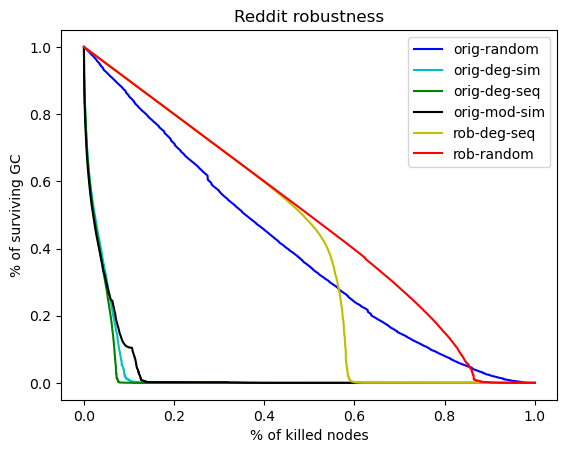

In [49]:
# read the files with the points of the robustness curves and plot the robustness curves

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

# read the data from the respective files, putting everything into a dict
# each element in the dict stores the two vectors with the data for the corresponding curve
bk = {}
bk["or_rand"] = read_xy("reddit_orig_frac_random.txt")
bk["or_deg_sim"] = read_xy("reddit_orig_frac_deg_sim.txt")
bk["or_deg_seq"] = read_xy("reddit_orig_frac_deg_seq.txt")
bk["or_mod_sim"] = read_xy("reddit_orig_frac_mod_sim.txt")
bk["rob_rand"] = read_xy("reddit_rob_frac_random.txt")
bk["rob_deg_seq"] = read_xy("reddit_rob_frac_deg_seq.txt")

# plot the 6 curves in the same plot
_ = plt.plot(bk["or_rand"][0], bk["or_rand"][1], 'b-', label = "orig-random")
_ = plt.plot(bk["or_deg_sim"][0], bk["or_deg_sim"][1], 'c-', label = "orig-deg-sim")
_ = plt.plot(bk["or_deg_seq"][0], bk["or_deg_seq"][1], 'g-', label = "orig-deg-seq")
_ = plt.plot(bk["or_mod_sim"][0], bk["or_mod_sim"][1], 'k-', label = "orig-mod-sim")
_ = plt.plot(bk["rob_deg_seq"][0], bk["rob_deg_seq"][1], 'y-', label = "rob-deg-seq")
_ = plt.plot(bk["rob_rand"][0], bk["rob_rand"][1], 'r-', label = "rob-random")
_ = plt.xlabel("% of killed nodes")
_ = plt.ylabel("% of surviving GC")
_ = plt.title("Reddit robustness")
_ = plt.legend()

# save the plot to a PDF file
pdf_file = PdfPages('Reddit_robustness.pdf')
plt.savefig(pdf_file, format="pdf")
pdf_file.close()